In [2]:
# ==============================================================================
# CELLULE 1: IMPORTATION DES LIBRAIRIES
# ==============================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from arch import arch_model
from sklearn.model_selection import train_test_split # Moins idéal pour séries temporelles, mais pour démo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from ipywidgets import interact, interactive, fixed, IntSlider
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Configuration de Matplotlib (optionnel)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# ==============================================================================
# CELLULE 2: CHOIX DE L'ACTION ET COLLECTE DES DONNÉES
# ==============================================================================
TICKER = 'NVDA' # Exemple: NVIDIA
START_DATE = '2010-01-01'
END_DATE = '2023-12-31' # Ajustez si nécessaire

# Téléchargement des données
try:
    data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)
    if data.empty:
        raise ValueError(f"No data found for ticker {TICKER} in the given date range.")
    print(f"Data for {TICKER} downloaded successfully. Shape: {data.shape}")
    print(data.head())
except Exception as e:
    print(f"Error downloading data for {TICKER}: {e}")
    # Quitter ou gérer l'erreur comme vous le souhaitez
    exit()

# S'assurer que l'index est un DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

print("\nData types before any processing:")
print(data.dtypes)

[*********************100%***********************]  1 of 1 completed

Data for NVDA downloaded successfully. Shape: (3522, 6)
Price      Adj Close    Close    High      Low     Open     Volume
Ticker          NVDA     NVDA    NVDA     NVDA     NVDA       NVDA
Date                                                              
2010-01-04  0.423884  0.46225  0.4655  0.45275  0.46275  800204000
2010-01-05  0.430073  0.46900  0.4740  0.46050  0.46050  728648000
2010-01-06  0.432824  0.47200  0.4730  0.46425  0.46875  649168000
2010-01-07  0.424342  0.46275  0.4715  0.45925  0.46950  547792000
2010-01-08  0.425259  0.46375  0.4670  0.45625  0.45900  478168000

Data types before any processing:
Price      Ticker
Adj Close  NVDA      float64
Close      NVDA      float64
High       NVDA      float64
Low        NVDA      float64
Open       NVDA      float64
Volume     NVDA        int64
dtype: object


Initial price_series type: <class 'pandas.core.series.Series'>, length: 3522
price_series length after dropna: 3522

--- log_returns ---
Type: <class 'pandas.core.series.Series'>
Shape: (3521,)
Is empty: False
Index example:
DatetimeIndex(['2010-01-05', '2010-01-06', '2010-01-07'], dtype='datetime64[ns]', name='Date', freq=None)
Head:
Date
2010-01-05    0.014497
2010-01-06    0.006376
2010-01-07   -0.019792
Name: Log_Returns, dtype: float64

--- realized_volatility ---
Type: <class 'pandas.core.series.Series'>
Shape: (3492,)
Is empty: False
Index example:
DatetimeIndex(['2010-02-17', '2010-02-18', '2010-02-19'], dtype='datetime64[ns]', name='Date', freq=None)
Head:
Date
2010-02-17    0.447837
2010-02-18    0.484814
2010-02-19    0.483838
Name: Realized_Vol, dtype: float64

--- Attempting to create df_model ---
Is log_returns a pd.Series? True
Is realized_volatility a pd.Series? True
DataFrame df_model created successfully using dictionary method.

Shape of df_model: (3492, 2)
Head of d

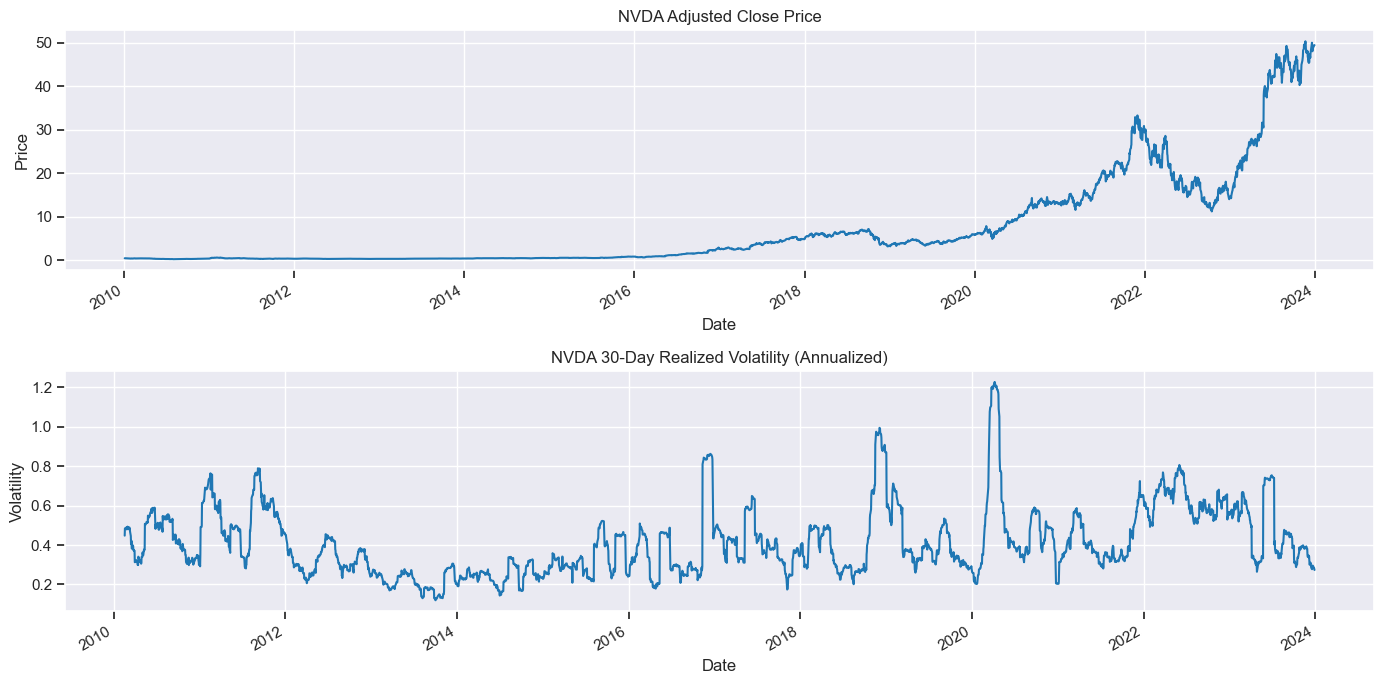

In [4]:
# ==============================================================================
# CELLULE 3: NETTOYAGE DES DONNÉES ET FORMATAGE / FEATURE ENGINEERING
# ==============================================================================

# 1. Sélectionner la colonne pertinente (Prix de clôture ajusté) AS A SERIES
price_series = data['Adj Close'].copy() # This should already be a Series
if isinstance(price_series, pd.DataFrame): # Defensive check
    if price_series.shape[1] == 1:
        price_series = price_series.iloc[:, 0] # Convert to Series if it's a single-column DataFrame
    else:
        print(f"Error: 'Adj Close' resulted in a multi-column DataFrame. Please check data for {TICKER}.")
        exit()
print(f"Initial price_series type: {type(price_series)}, length: {len(price_series)}")


# 2. Vérifier les valeurs manquantes et les supprimer ou les imputer
initial_len = len(price_series)
price_series.dropna(inplace=True)
if len(price_series) < initial_len:
    print(f"Dropped {initial_len - len(price_series)} NaN rows from price_series.")
print(f"price_series length after dropna: {len(price_series)}")

if price_series.empty:
    print(f"Price series for {TICKER} is empty after NaN removal. Exiting.")
    exit()
if len(price_series) < 2:
    print(f"Price series for {TICKER} has less than 2 data points after NaN removal. Cannot calculate returns. Exiting.")
    exit()

# 3. Calculer les log-rendements quotidiens
log_returns = np.log(price_series) - np.log(price_series.shift(1)) # Operations on Series produce Series
log_returns = log_returns.dropna()
log_returns.name = 'Log_Returns'

print(f"\n--- log_returns ---")
print(f"Type: {type(log_returns)}")
print(f"Shape: {log_returns.shape}")
print(f"Is empty: {log_returns.empty}")
if not log_returns.empty:
    print(f"Index example:\n{log_returns.index[:3]}")
    print(f"Head:\n{log_returns.head(3)}")
else:
    print(f"Log returns for {TICKER} are empty after dropna. Insufficient data. Exiting.")
    exit()

# 4. Calculer la volatilité historique (proxy de la volatilité réalisée)
VOL_WINDOW = 30
if len(log_returns) < VOL_WINDOW:
    print(f"Not enough log_returns ({len(log_returns)}) to calculate realized volatility with window {VOL_WINDOW}. Exiting.")
    exit()

realized_volatility = log_returns.rolling(window=VOL_WINDOW).std() * np.sqrt(252) # Operations on Series produce Series
realized_volatility = realized_volatility.dropna()
realized_volatility.name = 'Realized_Vol'

print(f"\n--- realized_volatility ---")
print(f"Type: {type(realized_volatility)}")
print(f"Shape: {realized_volatility.shape}")
print(f"Is empty: {realized_volatility.empty}")
if not realized_volatility.empty:
    print(f"Index example:\n{realized_volatility.index[:3]}")
    print(f"Head:\n{realized_volatility.head(3)}")
else:
    print(f"Realized volatility for {TICKER} is empty after dropna. Exiting.")
    exit()


# 5. Créer un DataFrame pour la modélisation
print("\n--- Attempting to create df_model ---")
print(f"Is log_returns a pd.Series? {isinstance(log_returns, pd.Series)}")
print(f"Is realized_volatility a pd.Series? {isinstance(realized_volatility, pd.Series)}")

df_model = None

try:
    df_model = pd.DataFrame({
        'Log_Returns': log_returns,
        'Realized_Vol': realized_volatility
    })
    print("DataFrame df_model created successfully using dictionary method.")
except ValueError as e:
    print(f"ValueError during dictionary-based DataFrame creation: {e}")
    print("Attempting alternative construction using pd.concat...")
    try:
        df_concat = pd.concat([log_returns, realized_volatility], axis=1)
        if 'Log_Returns' in df_concat.columns and 'Realized_Vol' in df_concat.columns:
            df_model = df_concat[['Log_Returns', 'Realized_Vol']].copy()
            print("DataFrame df_model created successfully using pd.concat.")
        else:
            print(f"Error: pd.concat did not produce expected columns. Columns found: {df_concat.columns}")
            df_model = None
    except Exception as concat_e:
        print(f"Error during pd.concat DataFrame construction: {concat_e}")
        df_model = None

if df_model is None:
    print("Failed to create df_model using all methods. Exiting.")
    exit()

df_model.dropna(inplace=True)

if df_model.empty:
    print(f"df_model for {TICKER} is empty after final dropna (aligning features). Insufficient overlapping data. Exiting.")
    exit()

print("\nShape of df_model:", df_model.shape)
print("Head of df_model:")
print(df_model.head())
print("Tail of df_model:")
print(df_model.tail())

# Visualisation (optionnel)
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
# Use the original price_series for plotting the price, not data[TICKER]['Adj Close'] which might be a DataFrame
price_series.plot(title=f'{TICKER} Adjusted Close Price')
plt.ylabel('Price')

plt.subplot(2, 1, 2)
if not df_model.empty:
    df_model['Realized_Vol'].plot(title=f'{TICKER} {VOL_WINDOW}-Day Realized Volatility (Annualized)')
    plt.ylabel('Volatility')
else:
    print("df_model is empty, skipping volatility plot.")
plt.tight_layout()
plt.show()

In [5]:
# ==============================================================================
# CELLULE 4: FONCTION D'ÉVALUATION ET SÉPARATION TRAIN/TEST
# ==============================================================================

# (In Cell 4)
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calcule et affiche RMSE, MAE, R2, and stores predictions."""
    global all_test_predictions # Allow modification of global dict
    global all_test_true_values

    y_true_eval = np.array(y_true).flatten()
    y_pred_eval = np.array(y_pred).flatten()
    
    # Handle potential length mismatch (e.g. from LSTM sequence creation)
    min_len = min(len(y_true_eval), len(y_pred_eval))
    if min_len == 0 :
        print(f"Cannot evaluate {model_name} due to zero length after alignment.")
        all_test_predictions[model_name] = np.array([])
        all_test_true_values[model_name] = np.array([])
        return {'Model': model_name, 'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}

    y_true_eval = y_true_eval[:min_len]
    y_pred_eval = y_pred_eval[:min_len]
    
    if len(y_true_eval) != len(y_pred_eval) and min_len > 0 : # Should not happen after above alignment
         print(f"Warning: Length mismatch for {model_name} AFTER alignment. y_true: {len(y_true_eval)}, y_pred: {len(y_pred_eval)}")


    rmse = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
    mae = mean_absolute_error(y_true_eval, y_pred_eval)
    r2 = r2_score(y_true_eval, y_pred_eval)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2:   {r2:.4f}")

    # Store predictions and corresponding true values
    all_test_predictions[model_name] = y_pred_eval
    all_test_true_values[model_name] = y_true_eval # Store the y_true used for this specific model's eval

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Fraction pour le test set
test_size_fraction = 0.2
if len(df_model) < 10: # Arbitrary small number, adjust as needed
    print(f"Warning: df_model has only {len(df_model)} rows. Test split might be too small or problematic.")
    # Potentially exit or adjust test_size_fraction
    if len(df_model) < 2:
        print("Exiting due to insufficient data for train/test split.")
        exit()

split_idx = int(len(df_model) * (1 - test_size_fraction))
if split_idx == 0 or split_idx == len(df_model):
    print(f"Warning: split_idx ({split_idx}) is at an extreme. Check data length and test_size_fraction.")
    # Adjust or exit if necessary
    if split_idx == 0 and len(df_model) > 0 : # Ensure at least one sample for training
        split_idx = 1
    elif split_idx == len(df_model) and len(df_model) > 0: # Ensure at least one sample for testing
        split_idx = len(df_model) -1
    if len(df_model) < 2 : # Cannot split if less than 2 samples
        print("Cannot perform train/test split with less than 2 samples. Exiting.")
        exit()


# Pour GARCH (entrée = log_returns, cible pour comparaison = realized_vol)
garch_train_returns = df_model['Log_Returns'][:split_idx].copy() * 100 # GARCH préfère souvent des rendements scalés
garch_test_returns = df_model['Log_Returns'][split_idx:].copy() * 100
garch_test_realized_vol = df_model['Realized_Vol'][split_idx:].copy()


# Pour ML (cible = realized_vol)
ml_target = df_model['Realized_Vol'].copy()
ml_train_target = ml_target[:split_idx].copy()
ml_test_target = ml_target[split_idx:].copy() # This is the same as garch_test_realized_vol

print(f"Total df_model length: {len(df_model)}")
print(f"Split index: {split_idx}")
print(f"GARCH Train returns shape: {garch_train_returns.shape}")
print(f"GARCH Test returns shape: {garch_test_returns.shape}")
print(f"GARCH Test realized_vol (target for GARCH eval) shape: {garch_test_realized_vol.shape}")

print(f"ML Train target shape: {ml_train_target.shape}")
print(f"ML Test target (target for ML eval) shape: {ml_test_target.shape}")


# DataFrame pour stocker les résultats
results_list = [] # Use a list of dicts, then convert to DataFrame at the end

if garch_test_returns.empty or garch_test_realized_vol.empty:
    print("Warning: GARCH test set is empty. GARCH models will not be evaluated.")
if ml_test_target.empty:
    print("Warning: ML test target is empty. ML models will not be evaluated.")



# (At the end of Cell 4, after results_list is initialized)
all_test_predictions = {} # To store y_pred for each model
all_test_true_values = {} # To store y_true for each model (in case lengths vary, e.g. for LSTM)

Total df_model length: 3492
Split index: 2793
GARCH Train returns shape: (2793,)
GARCH Test returns shape: (699,)
GARCH Test realized_vol (target for GARCH eval) shape: (699,)
ML Train target shape: (2793,)
ML Test target (target for ML eval) shape: (699,)


In [6]:
# ==============================================================================
# CELLULE 5: MODÉLISATION STATISTIQUE - MODÈLES GARCH (12 VARIANTS)
# ==============================================================================
garch_predictions = {}
garch_results_objects = {}
DISTRIBUTIONS = ['normal', 't', 'ged']

if not garch_train_returns.empty and not garch_test_returns.empty:
    HORIZON_LENGTH = len(garch_test_returns)

    # --- GARCH(1,1) with different distributions (3 variants) ---
    for dist_name in DISTRIBUTIONS:
        model_label = f"GARCH(1,1)_{dist_name}"
        print(f"\nFitting {model_label}...")
        try:
            garch_model_spec = arch_model(garch_train_returns, vol='Garch', p=1, q=1, dist=dist_name)
            garch_res = garch_model_spec.fit(disp='off', show_warning=False)
            garch_results_objects[model_label] = garch_res
            garch_forecast = garch_res.forecast(horizon=HORIZON_LENGTH, reindex=False)
            garch_pred_variance = garch_forecast.variance.values.flatten()
            if len(garch_pred_variance) != HORIZON_LENGTH:
                garch_pred_variance = np.full(HORIZON_LENGTH, np.nan)
            garch_pred_vol = np.sqrt(garch_pred_variance) / 100 * np.sqrt(252)
            garch_predictions[model_label] = garch_pred_vol
            results_list.append(evaluate_model(garch_test_realized_vol, garch_pred_vol, model_label))
        except Exception as e:
            print(f"Error fitting {model_label}: {e}")
            garch_predictions[model_label] = np.full(HORIZON_LENGTH, np.nan)

    # --- EGARCH(1,1) with different distributions (3 variants) ---
    for dist_name in DISTRIBUTIONS:
        model_label = f"EGARCH(1,1)_{dist_name}"
        print(f"\nFitting {model_label}...")
        try:
            egarch_model_spec = arch_model(garch_train_returns, vol='EGARCH', p=1, o=1, q=1, dist=dist_name)
            egarch_res = egarch_model_spec.fit(disp='off', show_warning=False)
            garch_results_objects[model_label] = egarch_res
            egarch_forecast = egarch_res.forecast(horizon=HORIZON_LENGTH, method='simulation', simulations=1000, reindex=False)
            egarch_pred_variance = egarch_forecast.variance.values.flatten()
            if len(egarch_pred_variance) != HORIZON_LENGTH:
                egarch_pred_variance = np.full(HORIZON_LENGTH, np.nan)
            egarch_pred_vol = np.sqrt(egarch_pred_variance) / 100 * np.sqrt(252)
            garch_predictions[model_label] = egarch_pred_vol
            results_list.append(evaluate_model(garch_test_realized_vol, egarch_pred_vol, model_label))
        except Exception as e:
            print(f"Error fitting {model_label}: {e}")
            garch_predictions[model_label] = np.full(HORIZON_LENGTH, np.nan)

    # --- APARCH(1,1) with different distributions (3 variants) ---
    for dist_name in DISTRIBUTIONS:
        model_label = f"APARCH(1,1)_{dist_name}"
        print(f"\nFitting {model_label}...")
        try:
            aparch_model_spec = arch_model(garch_train_returns, vol='APARCH', p=1, o=1, q=1, dist=dist_name)
            aparch_res = aparch_model_spec.fit(disp='off', show_warning=False)
            garch_results_objects[model_label] = aparch_res
            aparch_forecast = aparch_res.forecast(horizon=HORIZON_LENGTH, method='simulation', simulations=1000, reindex=False)
            aparch_pred_variance = aparch_forecast.variance.values.flatten()
            if len(aparch_pred_variance) != HORIZON_LENGTH:
                aparch_pred_variance = np.full(HORIZON_LENGTH, np.nan)
            aparch_pred_vol = np.sqrt(aparch_pred_variance) / 100 * np.sqrt(252)
            garch_predictions[model_label] = aparch_pred_vol
            results_list.append(evaluate_model(garch_test_realized_vol, aparch_pred_vol, model_label))
        except Exception as e:
            print(f"Error fitting {model_label}: {e}")
            garch_predictions[model_label] = np.full(HORIZON_LENGTH, np.nan)

    # --- GJR-GARCH(1,1) with different distributions (3 variants) ---
    for dist_name in DISTRIBUTIONS:
        model_label = f"GJR-GARCH(1,1)_{dist_name}"
        print(f"\nFitting {model_label}...")
        try:
            gjr_garch_model_spec = arch_model(garch_train_returns, vol='Garch', p=1, o=1, q=1, dist=dist_name)
            gjr_res = gjr_garch_model_spec.fit(disp='off', show_warning=False)
            garch_results_objects[model_label] = gjr_res
            gjr_garch_forecast = gjr_res.forecast(horizon=HORIZON_LENGTH, reindex=False)
            gjr_pred_variance = gjr_garch_forecast.variance.values.flatten()
            if len(gjr_pred_variance) != HORIZON_LENGTH:
                gjr_pred_variance = np.full(HORIZON_LENGTH, np.nan)
            gjr_pred_vol = np.sqrt(gjr_pred_variance) / 100 * np.sqrt(252)
            garch_predictions[model_label] = gjr_pred_vol
            results_list.append(evaluate_model(garch_test_realized_vol, gjr_pred_vol, model_label))
        except Exception as e:
            print(f"Error fitting {model_label}: {e}")
            garch_predictions[model_label] = np.full(HORIZON_LENGTH, np.nan)
else:
    print("Skipping GARCH model fitting due to empty train or test returns.")

# Stocker les prédictions GARCH alignées avec le test set pour les modèles hybrides
garch_preds_for_hybrid = pd.DataFrame(index=ml_test_target.index)
for model_name, preds in garch_predictions.items():
    # Ensure preds is a 1D array of the correct length before assigning
    if isinstance(preds, np.ndarray) and preds.ndim == 1 and len(preds) == len(ml_test_target.index):
        garch_preds_for_hybrid[f'{model_name}_Pred_Vol'] = preds
    else:
        print(f"Warning: Issue with GARCH predictions for {model_name}. Expected 1D array of length {len(ml_test_target.index)}, got type {type(preds)} with shape {getattr(preds, 'shape', 'N/A')}. Filling with NaN.")
        garch_preds_for_hybrid[f'{model_name}_Pred_Vol'] = np.nan

print("\nGARCH predictions for hybrid models (first 5 rows, few columns):")
if not garch_preds_for_hybrid.empty:
    print(garch_preds_for_hybrid.iloc[:, :min(5, garch_preds_for_hybrid.shape[1])].head())
    print(f"Total GARCH prediction columns for hybrid: {garch_preds_for_hybrid.shape[1]}") # Should be 12
else:
    print("garch_preds_for_hybrid is empty.")



Fitting GARCH(1,1)_normal...
--- GARCH(1,1)_normal Performance ---
RMSE: 0.1602
MAE:  0.1385
R2:   -0.2108

Fitting GARCH(1,1)_t...


--- GARCH(1,1)_t Performance ---
RMSE: 0.1511
MAE:  0.1281
R2:   -0.0763

Fitting GARCH(1,1)_ged...
--- GARCH(1,1)_ged Performance ---
RMSE: 0.1659
MAE:  0.1434
R2:   -0.2973

Fitting EGARCH(1,1)_normal...
--- EGARCH(1,1)_normal Performance ---
RMSE: 0.1471
MAE:  0.1310
R2:   -0.0209

Fitting EGARCH(1,1)_t...
--- EGARCH(1,1)_t Performance ---
RMSE: 0.1642
MAE:  0.1432
R2:   -0.2708

Fitting EGARCH(1,1)_ged...
--- EGARCH(1,1)_ged Performance ---
RMSE: 0.1717
MAE:  0.1455
R2:   -0.3902

Fitting APARCH(1,1)_normal...
--- APARCH(1,1)_normal Performance ---
RMSE: 0.1461
MAE:  0.1291
R2:   -0.0074

Fitting APARCH(1,1)_t...
--- APARCH(1,1)_t Performance ---
RMSE: 0.1756
MAE:  0.1481
R2:   -0.4541

Fitting APARCH(1,1)_ged...
--- APARCH(1,1)_ged Performance ---
RMSE: 0.1770
MAE:  0.1479
R2:   -0.4775

Fitting GJR-GARCH(1,1)_normal...
--- GJR-GARCH(1,1)_normal Performance ---
RMSE: 0.1583
MAE:  0.1375
R2:   -0.1820

Fitting GJR-GARCH(1,1)_t...
--- GJR-GARCH(1,1)_t Performance ---
RMSE: 0.1705
MA

In [7]:
# ==============================================================================
# CELLULE 6: PRÉPARATION DES DONNÉES POUR LES MODÈLES ML
# ==============================================================================
# Features: Lags de la volatilité réalisée et/ou lags des log-rendements
# La cible est df_model['Realized_Vol']

N_LAGS = 10 # Nombre de jours passés à utiliser comme features

df_ml = df_model.copy()
# Create lagged features from the original (non-scaled) log_returns
for i in range(1, N_LAGS + 1):
    df_ml[f'Log_Returns_Lag_{i}'] = df_ml['Log_Returns'].shift(i) # Lag original log_returns
    df_ml[f'Realized_Vol_Lag_{i}'] = df_ml['Realized_Vol'].shift(i)

df_ml = df_ml.dropna() # Supprimer les NaNs dus aux lags

if df_ml.empty:
    print("df_ml is empty after creating lagged features. Not enough data for N_LAGS. Exiting or skipping ML models.")
    # exit() # Or set a flag to skip ML parts
    SKIP_ML = True
else:
    SKIP_ML = False
    # Séparer X (features) et y (target)
    y_ml = df_ml['Realized_Vol'].copy()
    X_ml = df_ml.drop(['Log_Returns', 'Realized_Vol'], axis=1).copy()

    # Séparation train/test pour ML (re-aligning based on df_ml which has N_LAGS fewer rows)
    split_idx_ml = int(len(X_ml) * (1 - test_size_fraction))

    if split_idx_ml == 0 or split_idx_ml == len(X_ml):
        print(f"Warning: split_idx_ml ({split_idx_ml}) is at an extreme after lagging. Check data length.")
        if split_idx_ml == 0 and len(X_ml) > 0: split_idx_ml = 1
        elif split_idx_ml == len(X_ml) and len(X_ml) > 0: split_idx_ml = len(X_ml) -1
        if len(X_ml) < 2: SKIP_ML = True; print("Skipping ML due to insufficient data after lagging for split.")


    if not SKIP_ML:
        X_train_ml = X_ml[:split_idx_ml].copy()
        X_test_ml = X_ml[split_idx_ml:].copy()
        y_train_ml = y_ml[:split_idx_ml].copy()
        y_test_ml = y_ml[split_idx_ml:].copy() # This is the target for ML models

        print(f"X_train_ml shape: {X_train_ml.shape}, y_train_ml shape: {y_train_ml.shape}")
        print(f"X_test_ml shape: {X_test_ml.shape}, y_test_ml shape: {y_test_ml.shape}")

        # Mise à l'échelle des features pour certains modèles ML
        scaler_X = MinMaxScaler()
        X_train_ml_scaled = scaler_X.fit_transform(X_train_ml)
        X_test_ml_scaled = scaler_X.transform(X_test_ml)
    else:
        print("ML parts will be skipped due to data issues after lagging.")

# Ensure ml_test_target from Cell 4 is used for consistency if y_test_ml differs due to re-splitting
# However, y_test_ml is correctly aligned with X_test_ml now.
# The key is that predictions are evaluated against the appropriate y_test.

X_train_ml shape: (2785, 20), y_train_ml shape: (2785,)
X_test_ml shape: (697, 20), y_test_ml shape: (697,)


In [8]:
# ==============================================================================
# CELLULE 7: MACHINE LEARNING PUR - XGBOOST
# ==============================================================================
if not SKIP_ML and not X_train_ml.empty and not X_test_ml.empty:
    print("\nFitting XGBoost...")
    try:
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, early_stopping_rounds=10)
        xgb_model.fit(X_train_ml, y_train_ml, eval_set=[(X_test_ml, y_test_ml)], verbose=False) # XGBoost can use non-scaled
        xgb_preds = xgb_model.predict(X_test_ml)
        results_list.append(evaluate_model(y_test_ml, xgb_preds, "XGBoost"))
    except Exception as e:
        print(f"Error fitting XGBoost: {e}")
else:
    print("Skipping XGBoost due to data issues or SKIP_ML flag.")


Fitting XGBoost...
--- XGBoost Performance ---
RMSE: 0.0300
MAE:  0.0162
R2:   0.9575


In [9]:
# ==============================================================================
# CELLULE 8: MACHINE LEARNING PUR - RANDOM FOREST
# ==============================================================================
if not SKIP_ML and not X_train_ml.empty and not X_test_ml.empty:
    print("\nFitting Random Forest...")
    try:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train_ml, y_train_ml) # RF can use non-scaled
        rf_preds = rf_model.predict(X_test_ml)
        results_list.append(evaluate_model(y_test_ml, rf_preds, "Random Forest"))
    except Exception as e:
        print(f"Error fitting Random Forest: {e}")
else:
    print("Skipping Random Forest due to data issues or SKIP_ML flag.")


Fitting Random Forest...
--- Random Forest Performance ---
RMSE: 0.0292
MAE:  0.0157
R2:   0.9599


In [10]:
# ==============================================================================
# CELLULE 9: MACHINE LEARNING PUR - DEEP FEED FORWARD NEURAL NETWORK (DFFNN)
# ==============================================================================
if not SKIP_ML and X_train_ml_scaled.shape[0] > 0 and X_test_ml_scaled.shape[0] > 0 :
    print("\nFitting DFFNN...")
    try:
        dffnn_model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train_ml_scaled.shape[1],)),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        dffnn_model.compile(optimizer='adam', loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

        history_dffnn = dffnn_model.fit(X_train_ml_scaled, y_train_ml,
                                        epochs=100,
                                        batch_size=32,
                                        validation_split=0.1,
                                        callbacks=[early_stopping],
                                        verbose=0)

        dffnn_preds = dffnn_model.predict(X_test_ml_scaled).flatten()
        results_list.append(evaluate_model(y_test_ml, dffnn_preds, "DFFNN"))
    except Exception as e:
        print(f"Error fitting DFFNN: {e}")
else:
    print("Skipping DFFNN due to data issues or SKIP_ML flag.")


Fitting DFFNN...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
--- DFFNN Performance ---
RMSE: 0.0520
MAE:  0.0419
R2:   0.8726


In [11]:
# ==============================================================================
# CELLULE 10: MACHINE LEARNING PUR - LSTM
# ==============================================================================

# LSTM expects input 3D: [samples, timesteps, features]
# We need to reshape X_train_ml_scaled and X_test_ml_scaled

if not SKIP_ML and X_train_ml_scaled.shape[0] > 0 and X_test_ml_scaled.shape[0] > 0:
    # For a simple LSTM using lagged features directly:
    # Treat N_LAGS as 'timesteps' and each type of lag (Return, Vol) as 'features'
    # Original X_train_ml had Log_Returns_Lag_1...N, Realized_Vol_Lag_1...N
    # So, 2*N_LAGS features.
    # If we want N_LAGS timesteps, we need to reshape.
    # Assuming X_train_ml_scaled has features ordered: [RL1, RL2,..., RVL1, RVL2,...]
    # This reshaping is a bit non-standard for typical LSTM on raw sequences.
    # A more common LSTM approach:
    
    def create_lstm_sequences(features_data, target_data, n_steps_in):
        X, y = [], []
        # Ensure target_data is aligned with the END of feature sequences
        # The features_data should be all available features up to t-1 for predicting y at t
        for i in range(n_steps_in, len(features_data)):
            # sequence of features from i-n_steps_in to i-1
            X.append(features_data[i-n_steps_in:i, :])
            # target at time i
            y.append(target_data[i])
        return np.array(X), np.array(y)

    N_STEPS_LSTM = 5 # Number of past time steps to look at for each sample

    # Use X_ml and y_ml (before train/test split) to create sequences, then split
    # Scale X_ml for LSTM
    scaler_lstm_feat = MinMaxScaler()
    X_ml_scaled_for_lstm_seq = scaler_lstm_feat.fit_transform(X_ml) # Scale all of X_ml

    # y_ml is the target, does not need scaling here if loss function handles it
    X_lstm_sequences, y_lstm_sequences = create_lstm_sequences(X_ml_scaled_for_lstm_seq, y_ml.values, N_STEPS_LSTM)

    if X_lstm_sequences.size == 0:
        print(f"Not enough data to create LSTM sequences with N_STEPS_LSTM = {N_STEPS_LSTM}")
        SKIP_LSTM = True
    else:
        SKIP_LSTM = False
        # Split sequences into train/test
        split_idx_lstm_seq = int(len(X_lstm_sequences) * (1 - test_size_fraction))
        
        if split_idx_lstm_seq == 0 or split_idx_lstm_seq == len(X_lstm_sequences):
            print(f"Warning: split_idx_lstm_seq ({split_idx_lstm_seq}) is at an extreme.")
            if split_idx_lstm_seq == 0 and len(X_lstm_sequences) > 0: split_idx_lstm_seq = 1
            elif split_idx_lstm_seq == len(X_lstm_sequences) and len(X_lstm_sequences) > 0: split_idx_lstm_seq = len(X_lstm_sequences)-1
            if len(X_lstm_sequences) < 2: SKIP_LSTM = True

        if not SKIP_LSTM:
            X_train_lstm, X_test_lstm = X_lstm_sequences[:split_idx_lstm_seq], X_lstm_sequences[split_idx_lstm_seq:]
            y_train_lstm, y_test_lstm = y_lstm_sequences[:split_idx_lstm_seq], y_lstm_sequences[split_idx_lstm_seq:]

            print(f"X_train_lstm shape: {X_train_lstm.shape}, y_train_lstm shape: {y_train_lstm.shape}")
            print(f"X_test_lstm shape: {X_test_lstm.shape}, y_test_lstm shape: {y_test_lstm.shape}")

            print("\nFitting LSTM...")
            try:
                lstm_model = Sequential([
                    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
                    Dropout(0.2),
                    LSTM(50, activation='relu'),
                    Dropout(0.2),
                    Dense(25, activation='relu'),
                    Dense(1)
                ])
                lstm_model.compile(optimizer='adam', loss='mean_squared_error')
                early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

                history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm,
                                              epochs=100,
                                              batch_size=32,
                                              validation_split=0.1,
                                              callbacks=[early_stopping_lstm],
                                              verbose=0)

                lstm_preds = lstm_model.predict(X_test_lstm).flatten()
                results_list.append(evaluate_model(y_test_lstm, lstm_preds, "LSTM"))
            except Exception as e:
                print(f"Error fitting LSTM: {e}")
        else:
            print("Skipping LSTM training due to insufficient sequence data for split.")
else:
    print("Skipping LSTM due to data issues from previous steps or SKIP_ML flag.")
    SKIP_LSTM = True # Ensure it's set if ML was skipped earlier

X_train_lstm shape: (2781, 5, 20), y_train_lstm shape: (2781,)
X_test_lstm shape: (696, 5, 20), y_test_lstm shape: (696,)

Fitting LSTM...
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
--- LSTM Performance ---
RMSE: 0.0472
MAE:  0.0292
R2:   0.8951


In [12]:
# ==============================================================================
# CELLULE 11: MODÈLES HYBRIDES (COMPLETE WITH ALL ML MODELS)
# ==============================================================================
if not SKIP_ML:
    print("\n--- Preparing Data for Hybrid Models (with GARCH distributions) ---")
    # ... (The GARCH feature generation part for `garch_features_for_train_hybrid`
    # and the creation of `X_train_hybrid_final` and `X_test_hybrid_final`
    # should be the same as in the previous correct version of Cell 11.
    # I'll repeat it here for completeness of this cell execution)

    garch_features_for_train_hybrid = pd.DataFrame(index=X_train_ml.index)
    DISTRIBUTIONS_CELL11 = ['normal', 't', 'ged'] # Ensure this is defined or passed

    if not garch_train_returns.empty:
        garch_model_types_cell11 = {
            "GARCH(1,1)": {'vol': 'Garch', 'p': 1, 'o': 0, 'q': 1},
            "EGARCH(1,1)": {'vol': 'EGARCH', 'p': 1, 'o': 1, 'q': 1},
            "APARCH(1,1)": {'vol': 'APARCH', 'p': 1, 'o': 1, 'q': 1},
            "GJR-GARCH(1,1)": {'vol': 'Garch', 'p': 1, 'o': 1, 'q': 1}
        }
        for model_key, model_params in garch_model_types_cell11.items():
            for dist_name in DISTRIBUTIONS_CELL11:
                col_name = f"{model_key}_{dist_name}_Pred_Vol"
                try:
                    m_train = arch_model(garch_train_returns, **model_params, dist=dist_name).fit(disp='off', show_warning=False)
                    cond_vol = m_train.conditional_volatility / 100 * np.sqrt(252)
                    garch_features_for_train_hybrid[col_name] = cond_vol.reindex(X_train_ml.index).fillna(method='bfill').fillna(method='ffill')
                except Exception as e:
                    print(f"Error generating {col_name} train feature: {e}")
                    garch_features_for_train_hybrid[col_name] = 0 # Fallback
    else:
        print("garch_train_returns is empty, cannot generate GARCH features for hybrid training. Filling with zeros.")
        # Fallback logic as before...

    # Combine base ML features with ALL 12 GARCH features/predictions
    X_train_hybrid_base = X_train_ml.join(garch_features_for_train_hybrid, how='left').fillna(method='bfill').fillna(method='ffill')
    X_test_hybrid_base = X_test_ml.join(garch_preds_for_hybrid, how='left').fillna(method='bfill').fillna(method='ffill')
    
    common_hybrid_cols = list(X_test_ml.columns) + list(garch_preds_for_hybrid.columns) # Order: base ML, then GARCH preds
    
    for col in common_hybrid_cols:
        if col not in X_train_hybrid_base.columns:
            print(f"Warning: Column '{col}' missing in X_train_hybrid_base. Adding with 0.")
            X_train_hybrid_base[col] = 0
        if col not in X_test_hybrid_base.columns:
            print(f"Warning: Column '{col}' missing in X_test_hybrid_base. Adding with 0.")
            X_test_hybrid_base[col] = 0
            
    X_train_hybrid_final = X_train_hybrid_base[common_hybrid_cols].copy()
    X_test_hybrid_final = X_test_hybrid_base[common_hybrid_cols].copy()

    print(f"X_train_hybrid_final shape: {X_train_hybrid_final.shape}")
    print(f"X_test_hybrid_final shape: {X_test_hybrid_final.shape}")

    # --- Iterate through Specific GARCH_Distribution types and ML models for hybrid approaches ---
    base_ml_feature_cols = list(X_train_ml.columns)

    # garch_preds_for_hybrid.columns contains all the 12 GARCH feature names (e.g., "GARCH(1,1)_norm_Pred_Vol")
    for specific_garch_feature_col_name in garch_preds_for_hybrid.columns:
        
        print(f"\n--- Hybrids using ML base features + {specific_garch_feature_col_name} ---")

        current_hybrid_feature_cols_for_model = base_ml_feature_cols + [specific_garch_feature_col_name]
        
        if not all(col in X_train_hybrid_final.columns for col in current_hybrid_feature_cols_for_model):
            print(f"Skipping hybrids for {specific_garch_feature_col_name} due to missing columns in X_train_hybrid_final.")
            continue
        if not all(col in X_test_hybrid_final.columns for col in current_hybrid_feature_cols_for_model):
            print(f"Skipping hybrids for {specific_garch_feature_col_name} due to missing columns in X_test_hybrid_final.")
            continue

        current_X_train_h_specific = X_train_hybrid_final[current_hybrid_feature_cols_for_model].copy()
        current_X_test_h_specific = X_test_hybrid_final[current_hybrid_feature_cols_for_model].copy()

        # Scale features for DFFNN and LSTM
        scaler_specific_hybrid = MinMaxScaler()
        current_X_train_h_specific_scaled = scaler_specific_hybrid.fit_transform(current_X_train_h_specific)
        current_X_test_h_specific_scaled = scaler_specific_hybrid.transform(current_X_test_h_specific)
        
        target_y_train = y_train_ml # From Cell 6, aligned with X_train_ml
        target_y_test = y_test_ml   # From Cell 6, aligned with X_test_ml

        # --- 1. DFFNN + Specific GARCH_Distribution ---
        model_name_dffnn_spec = f"DFFNN_Hybrid_with_{specific_garch_feature_col_name.replace('_Pred_Vol','')}"
        print(f"Fitting {model_name_dffnn_spec}...")
        if current_X_train_h_specific_scaled.shape[0] > 0 and current_X_test_h_specific_scaled.shape[0] > 0:
            try:
                dffnn_hybrid_model_spec = Sequential([
                    Dense(128, activation='relu', input_shape=(current_X_train_h_specific_scaled.shape[1],)),
                    Dropout(0.2), Dense(64, activation='relu'), Dropout(0.2),
                    Dense(32, activation='relu'), Dense(1)
                ])
                dffnn_hybrid_model_spec.compile(optimizer='adam', loss='mean_squared_error')
                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
                dffnn_hybrid_model_spec.fit(current_X_train_h_specific_scaled, target_y_train, 
                                            epochs=100, batch_size=32, validation_split=0.1, 
                                            callbacks=[early_stop], verbose=0)
                preds_dffnn = dffnn_hybrid_model_spec.predict(current_X_test_h_specific_scaled).flatten()
                results_list.append(evaluate_model(target_y_test, preds_dffnn, model_name_dffnn_spec))
            except Exception as e:
                print(f"Error fitting {model_name_dffnn_spec}: {e}")
        else:
            print(f"Skipping {model_name_dffnn_spec} due to empty training or testing data after selection.")
        
        # --- 2. XGBoost + Specific GARCH_Distribution (use non-scaled current_X_train_h_specific) ---
        model_name_xgb_spec = f"XGBoost_Hybrid_with_{specific_garch_feature_col_name.replace('_Pred_Vol','')}"
        print(f"Fitting {model_name_xgb_spec}...")
        if current_X_train_h_specific.shape[0] > 0 and current_X_test_h_specific.shape[0] > 0:
            try:
                xgb_hybrid_model_spec = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, early_stopping_rounds=10)
                xgb_hybrid_model_spec.fit(current_X_train_h_specific, target_y_train, 
                                          eval_set=[(current_X_test_h_specific, target_y_test)], verbose=False)
                preds_xgb = xgb_hybrid_model_spec.predict(current_X_test_h_specific)
                results_list.append(evaluate_model(target_y_test, preds_xgb, model_name_xgb_spec))
            except Exception as e:
                print(f"Error fitting {model_name_xgb_spec}: {e}")
        else:
            print(f"Skipping {model_name_xgb_spec} due to empty training or testing data.")

        # --- 3. Random Forest + Specific GARCH_Distribution (use non-scaled current_X_train_h_specific) ---
        model_name_rf_spec = f"RF_Hybrid_with_{specific_garch_feature_col_name.replace('_Pred_Vol','')}"
        print(f"Fitting {model_name_rf_spec}...")
        if current_X_train_h_specific.shape[0] > 0 and current_X_test_h_specific.shape[0] > 0:
            try:
                rf_hybrid_model_spec = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
                rf_hybrid_model_spec.fit(current_X_train_h_specific, target_y_train)
                preds_rf = rf_hybrid_model_spec.predict(current_X_test_h_specific)
                results_list.append(evaluate_model(target_y_test, preds_rf, model_name_rf_spec))
            except Exception as e:
                print(f"Error fitting {model_name_rf_spec}: {e}")
        else:
            print(f"Skipping {model_name_rf_spec} due to empty training or testing data.")
            
        # --- 4. LSTM + Specific GARCH_Distribution ---
        # N_STEPS_LSTM should be defined (e.g., from Cell 10)
        model_name_lstm_spec = f"LSTM_Hybrid_with_{specific_garch_feature_col_name.replace('_Pred_Vol','')}"
        print(f"Preparing & Fitting {model_name_lstm_spec}...")
        if current_X_train_h_specific_scaled.shape[0] > N_STEPS_LSTM and current_X_test_h_specific_scaled.shape[0] > N_STEPS_LSTM :
            # Create sequences using the current specific hybrid features (scaled)
            # Target should be aligned with the end of sequences.
            # `target_y_train` and `target_y_test` are currently aligned with the non-sequential `current_X_...` data.
            
            # Create training sequences
            X_lstm_h_train_seq, y_lstm_h_train_seq_target = create_lstm_sequences(
                current_X_train_h_specific_scaled, # Scaled training features for this hybrid
                target_y_train.values,             # Training targets
                N_STEPS_LSTM
            )
            
            # Create testing sequences
            X_lstm_h_test_seq, y_lstm_h_test_seq_target = create_lstm_sequences(
                current_X_test_h_specific_scaled,  # Scaled testing features for this hybrid
                target_y_test.values,              # Testing targets
                N_STEPS_LSTM
            )
            
            if X_lstm_h_train_seq.size > 0 and X_lstm_h_test_seq.size > 0:
                try:
                    lstm_hybrid_model_spec = Sequential([
                        LSTM(50, activation='relu', input_shape=(X_lstm_h_train_seq.shape[1], X_lstm_h_train_seq.shape[2]), return_sequences=True),
                        Dropout(0.2), LSTM(50, activation='relu'), Dropout(0.2),
                        Dense(25, activation='relu'), Dense(1)
                    ])
                    lstm_hybrid_model_spec.compile(optimizer='adam', loss='mean_squared_error')
                    early_stop_lstm_h = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
                    
                    # Fit on training sequences
                    lstm_hybrid_model_spec.fit(X_lstm_h_train_seq, y_lstm_h_train_seq_target, 
                                               epochs=100, batch_size=32, validation_split=0.1, 
                                               callbacks=[early_stop_lstm_h], verbose=0)
                    
                    # Predict on testing sequences
                    preds_lstm_h = lstm_hybrid_model_spec.predict(X_lstm_h_test_seq).flatten()
                    results_list.append(evaluate_model(y_lstm_h_test_seq_target, preds_lstm_h, model_name_lstm_spec))
                except Exception as e:
                    print(f"Error fitting {model_name_lstm_spec}: {e}")
            else:
                print(f"Skipping {model_name_lstm_spec} due to no train or test sequences created (after create_lstm_sequences).")
        else:
            print(f"Skipping {model_name_lstm_spec} due to insufficient data for LSTM sequences (before create_lstm_sequences).")

    print("Completed iterating through specific GARCH_Distribution hybrid combinations.")
else:
    print("Skipping Hybrid Models due to SKIP_ML flag or earlier data issues.")

# Cell 12 for final comparison would remain the same.
# final_results_df = pd.DataFrame(results_list)
# print(final_results_df.sort_values(by='RMSE'))


--- Preparing Data for Hybrid Models (with GARCH distributions) ---
X_train_hybrid_final shape: (2785, 32)
X_test_hybrid_final shape: (697, 32)

--- Hybrids using ML base features + GARCH(1,1)_normal_Pred_Vol ---
Fitting DFFNN_Hybrid_with_GARCH(1,1)_normal...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--- DFFNN_Hybrid_with_GARCH(1,1)_normal Performance ---
RMSE: 0.0530
MAE:  0.0398
R2:   0.8678
Fitting XGBoost_Hybrid_with_GARCH(1,1)_normal...
--- XGBoost_Hybrid_with_GARCH(1,1)_normal Performance ---
RMSE: 0.0319
MAE:  0.0187
R2:   0.9521
Fitting RF_Hybrid_with_GARCH(1,1)_normal...
--- RF_Hybrid_with_GARCH(1,1)_normal Performance ---
RMSE: 0.0292
MAE:  0.0163
R2:   0.9598
Preparing & Fitting LSTM_Hybrid_with_GARCH(1,1)_normal...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
--- LSTM_Hybrid_with_GARCH(1,1)_normal Performance ---
RMSE: 0.0616
MAE:  0.0463
R2:   0.8226

--- Hybrids using ML base features + GARCH(1,1)_t_Pred_Vol ---
Fitting DFFNN_Hybrid_with_GARCH(1,1)_t...
22/22 ━━━━━━━━━━━━━━━━━━━



--- Final Model Comparison ---
                                Model      RMSE       MAE        R2
42  RF_Hybrid_with_APARCH(1,1)_normal  0.028802  0.015401  0.960974
30  RF_Hybrid_with_EGARCH(1,1)_normal  0.028949  0.015747  0.960575
13                      Random Forest  0.029184  0.015673  0.959931
22        RF_Hybrid_with_GARCH(1,1)_t  0.029191  0.015758  0.959913
18   RF_Hybrid_with_GARCH(1,1)_normal  0.029228  0.016288  0.959810
..                                ...       ...       ...       ...
2                      GARCH(1,1)_ged  0.165855  0.143447 -0.297346
10                   GJR-GARCH(1,1)_t  0.170544  0.139344 -0.371730
5                     EGARCH(1,1)_ged  0.171691  0.145504 -0.390246
7                       APARCH(1,1)_t  0.175591  0.148123 -0.454117
8                     APARCH(1,1)_ged  0.176998  0.147853 -0.477518

[64 rows x 4 columns]


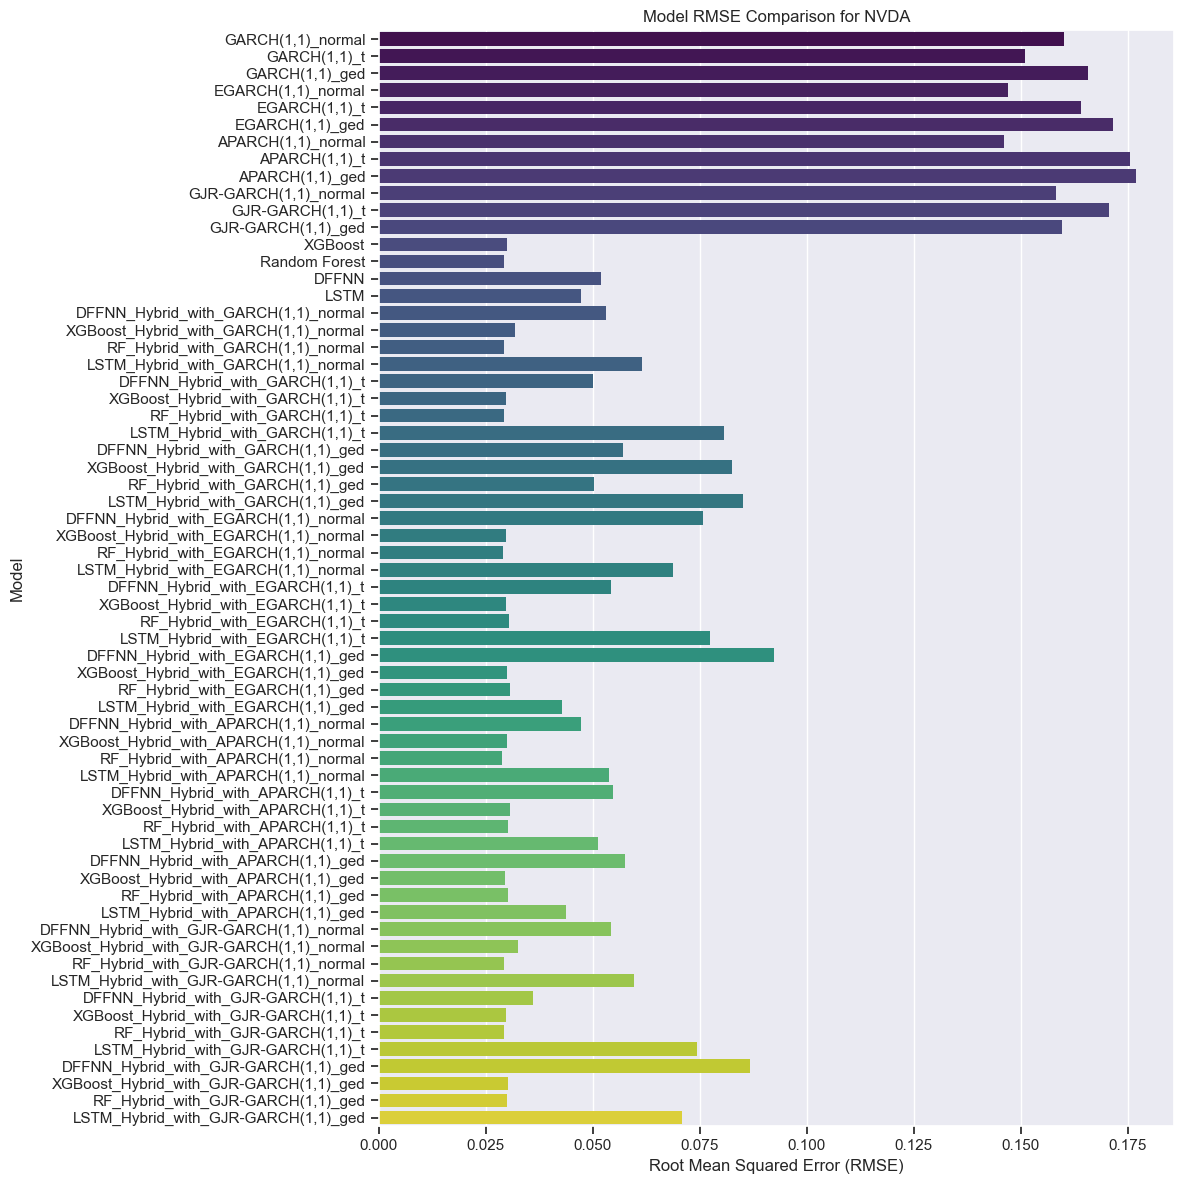

In [13]:
# ==============================================================================
# CELLULE 12: COMPARAISON FINALE DES MODÈLES
# ==============================================================================
if results_list: # Check if the list is not empty
    final_results_df = pd.DataFrame(results_list)
    print("\n\n--- Final Model Comparison ---")
    print(final_results_df.sort_values(by='RMSE')) # Sort by RMSE (lower is better)
else:
    print("\nNo models were successfully evaluated to compare.")

# Visualisation des résultats (exemple: bar chart of RMSEs)
if results_list:
    plt.figure(figsize=(12, 12))
    sns.barplot(data=final_results_df, x='RMSE', y='Model', palette='viridis')
    plt.title(f'Model RMSE Comparison for {TICKER}')
    plt.xlabel('Root Mean Squared Error (RMSE)')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

In [14]:
# ==============================================================================
# CELL 14 (Modified): INTERACTIVE PLOT OF TOP MODELS WITH EXTENDED FORECAST
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact # Removed unused ones for this cell
from IPython.display import display
from arch import arch_model # Make sure arch_model is imported for refitting

print("\n--- Setting up Interactive Plot for Top Model Predictions with Extended Forecast ---")

# --- Step 1: Verify necessary data exists ---
# (Keep the same verification block as before)
if 'final_results_df' not in globals() or not isinstance(final_results_df, pd.DataFrame) or final_results_df.empty:
    print("Error: `final_results_df` is not available, not a DataFrame, or is empty.")
elif 'all_test_predictions' not in globals() or not isinstance(all_test_predictions, dict) or not all_test_predictions:
    print("Error: `all_test_predictions` dictionary is not available or is empty.")
elif 'all_test_true_values' not in globals() or not isinstance(all_test_true_values, dict) or not all_test_true_values:
    print("Error: `all_test_true_values` dictionary is not available or is empty.")
elif ('y_test_ml' not in globals() or not hasattr(y_test_ml, 'index')) and \
     ('garch_test_realized_vol' not in globals() or not hasattr(garch_test_realized_vol, 'index')):
    print("Error: Main test set index for plotting actuals is not available.")
elif 'df_model' not in globals() or not isinstance(df_model, pd.DataFrame) or df_model.empty:
    print("Error: `df_model` (containing full historical data) is not available or empty for extended forecast refit.")
elif 'TICKER' not in globals():
    print("Error: `TICKER` variable is not defined.")
else:
    print("All necessary data structures for interactive plot appear to be available.")

    # --- Step 2: Get top 4 models by RMSE ---
    top_4_models_df = final_results_df.nsmallest(4, 'RMSE').copy()
    top_4_model_names = top_4_models_df['Model'].tolist()

    if not top_4_model_names:
        print("No models found in top_4_models_df. Cannot create interactive plot.")
    else:
        print(f"Top 4 models available for interactive plotting: {top_4_model_names}")

        # --- Step 3: Determine the reference true values and index for the historical part ---
        reference_actual_volatility_test_period = None
        reference_datetime_index_test_period = None
        if 'y_test_ml' in globals() and isinstance(y_test_ml, pd.Series) and not y_test_ml.empty:
            reference_actual_volatility_test_period = y_test_ml.values
            reference_datetime_index_test_period = y_test_ml.index
        elif 'garch_test_realized_vol' in globals() and isinstance(garch_test_realized_vol, pd.Series) and not garch_test_realized_vol.empty:
            reference_actual_volatility_test_period = garch_test_realized_vol.values
            reference_datetime_index_test_period = garch_test_realized_vol.index
        
        if reference_actual_volatility_test_period is None or reference_datetime_index_test_period is None:
            print("Could not establish a primary reference for actual volatility during test period. Interactive plot cannot proceed.")
        else:
            # --- Parameters for extended forecast ---
            FORECAST_YEARS = 3
            TRADING_DAYS_PER_YEAR = 252
            EXTENDED_HORIZON = TRADING_DAYS_PER_YEAR * FORECAST_YEARS
            
            # Full historical log returns for refitting GARCH models
            full_historical_log_returns_scaled = df_model['Log_Returns'].copy() * 100
            last_actual_date_for_forecast_origin = df_model.index[-1]


            # --- Step 4: Define the plotting function for interactivity ---
            def plot_single_model_with_extension(selected_model_name):
                plt.figure(figsize=(20, 10)) # Made wider to accommodate more data
                
                # --- Part A: Plot historical actuals and the model's test period predictions ---
                # Plot Actual Realized Volatility for the test period
                plt.plot(reference_datetime_index_test_period, reference_actual_volatility_test_period, 
                         label='Actual Realized Volatility (Test Period)', color='black', linewidth=2.0, alpha=0.9, zorder=10)

                # Plot the model's predictions over the test period (from `all_test_predictions`)
                if selected_model_name in all_test_predictions and selected_model_name in all_test_true_values:
                    test_period_predictions = all_test_predictions[selected_model_name]
                    
                    if len(test_period_predictions) > 0:
                        current_plot_index_test = None
                        if len(test_period_predictions) == len(reference_actual_volatility_test_period):
                            current_plot_index_test = reference_datetime_index_test_period
                        elif len(test_period_predictions) < len(reference_actual_volatility_test_period):
                            current_plot_index_test = reference_datetime_index_test_period[-len(test_period_predictions):]
                        else: # Predictions longer or other mismatch
                            min_plot_len_test = len(test_period_predictions) # Assume predictions define the length to plot
                            current_plot_index_test = reference_datetime_index_test_period[-min_plot_len_test:] if min_plot_len_test <= len(reference_datetime_index_test_period) else pd.RangeIndex(stop=min_plot_len_test)


                        if current_plot_index_test is not None and len(current_plot_index_test) == len(test_period_predictions):
                            model_metrics = top_4_models_df[top_4_models_df["Model"] == selected_model_name].iloc[0]
                            plt.plot(current_plot_index_test, test_period_predictions, 
                                     label=f'{selected_model_name} (Test Period Pred.)\n(RMSE: {model_metrics["RMSE"]:.4f})', 
                                     color='red', alpha=0.80, linestyle='--', linewidth=1.8, zorder=5)
                        else:
                            print(f"Could not align test period predictions for '{selected_model_name}'.")
                    else:
                        print(f"No test period predictions stored for '{selected_model_name}'.")
                else:
                    print(f"Test period predictions or true values for model '{selected_model_name}' not found.")

                # --- Part B: Generate and plot the extended 3-year forecast for the selected model ---
                # This part is primarily for GARCH-family models. ML models require retraining or different setup for pure future forecast.
                # We will attempt to refit and forecast if it's a GARCH-family model from the name.
                
                is_garch_family_model = any(garch_base in selected_model_name for garch_base in ["GARCH(1,1)", "EGARCH(1,1)", "APARCH(1,1)", "GJR-GARCH(1,1)"])

                if is_garch_family_model:
                    print(f"\nGenerating extended {FORECAST_YEARS}-year forecast for GARCH-family model: {selected_model_name}")
                    model_type_parts = selected_model_name.split('_')
                    garch_family_str = model_type_parts[0] + "_" + model_type_parts[1] if len(model_type_parts) > 1 and model_type_parts[1] in ["norm", "t", "ged"] else model_type_parts[0]
                    # More robust parsing:
                    garch_base_name = ""
                    distribution_name = 'normal' # Default
                    if "GARCH(1,1)" in selected_model_name: garch_base_name = "GARCH(1,1)"
                    elif "EGARCH(1,1)" in selected_model_name: garch_base_name = "EGARCH(1,1)"
                    elif "APARCH(1,1)" in selected_model_name: garch_base_name = "APARCH(1,1)"
                    elif "GJR-GARCH(1,1)" in selected_model_name: garch_base_name = "GJR-GARCH(1,1)"
                    
                    for dist_cand in ['_normal', '_t', '_ged']:
                        if dist_cand in selected_model_name:
                            distribution_name = dist_cand[1:]
                            break
                    
                    garch_params_dict = {}
                    if garch_base_name == "GARCH(1,1)": garch_params_dict = {'vol': 'Garch', 'p': 1, 'o': 0, 'q': 1}
                    elif garch_base_name == "EGARCH(1,1)": garch_params_dict = {'vol': 'EGARCH', 'p': 1, 'o': 1, 'q': 1}
                    elif garch_base_name == "APARCH(1,1)": garch_params_dict = {'vol': 'APARCH', 'p': 1, 'o': 1, 'q': 1}
                    elif garch_base_name == "GJR-GARCH(1,1)": garch_params_dict = {'vol': 'Garch', 'p': 1, 'o': 1, 'q': 1}

                    if garch_params_dict:
                        try:
                            print(f"Refitting {garch_base_name} with {distribution_name} dist on full history...")
                            refitted_model_spec = arch_model(full_historical_log_returns_scaled, dist=distribution_name, **garch_params_dict)
                            # Use last_obs to ensure it uses data up to the point of forecast
                            refitted_model_results = refitted_model_spec.fit(disp='off', show_warning=False, last_obs=full_historical_log_returns_scaled.index[-1])

                            forecast_mthd = 'simulation' if garch_base_name.startswith("EGARCH") or garch_base_name.startswith("APARCH") else 'analytic'
                            
                            print(f"Forecasting {EXTENDED_HORIZON} steps into the future using method: {forecast_mthd}...")
                            if forecast_mthd == 'simulation':
                                extended_fc = refitted_model_results.forecast(horizon=EXTENDED_HORIZON, method='simulation', simulations=1000, reindex=False)
                            else:
                                extended_fc = refitted_model_results.forecast(horizon=EXTENDED_HORIZON, reindex=False)
                            
                            future_pred_var = extended_fc.variance.values.flatten()

                            if len(future_pred_var) != EXTENDED_HORIZON:
                                if len(future_pred_var) < EXTENDED_HORIZON:
                                    future_pred_var = np.pad(future_pred_var, (0, EXTENDED_HORIZON - len(future_pred_var)), 'edge') # Pad with last known value
                                else:
                                    future_pred_var = future_pred_var[:EXTENDED_HORIZON]
                            
                            future_pred_vol_extended = np.sqrt(future_pred_var) / 100 * np.sqrt(TRADING_DAYS_PER_YEAR)
                            
                            future_dates = pd.date_range(start=last_actual_date_for_forecast_origin + pd.Timedelta(days=1), 
                                                         periods=EXTENDED_HORIZON, freq='B') # Business day frequency

                            if len(future_dates) == len(future_pred_vol_extended):
                                plt.plot(future_dates, future_pred_vol_extended, 
                                         label=f'{selected_model_name} ({FORECAST_YEARS}yr Extended Forecast)', 
                                         color='green', linestyle=':', linewidth=2.0, alpha=0.85)
                            else:
                                print(f"Length mismatch between future dates ({len(future_dates)}) and extended forecast ({len(future_pred_vol_extended)}) for {selected_model_name}.")

                        except Exception as e:
                            print(f"Error during extended GARCH forecast for {selected_model_name}: {e}")
                    else:
                        print(f"Cannot perform extended forecast for non-GARCH model '{selected_model_name}' with this logic.")
                elif "Hybrid" in selected_model_name: # For ML-Hybrid models
                    print(f"Note: Extended pure forecast for ML-hybrid models like '{selected_model_name}' is complex. "
                          f"It would require forecasting all its inputs (base ML lags AND the GARCH component) into the future. "
                          f"This plot will only show its test period performance.")
                else: # For pure ML models
                     print(f"Note: Extended pure forecast for pure ML models like '{selected_model_name}' requires a different setup (e.g., iterative forecasting). "
                           f"This plot will only show its test period performance.")


                plt.title(f'{TICKER} - {selected_model_name} vs Actual & Extended Forecast', fontsize=16)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Annualized Volatility', fontsize=12)
                plt.legend(fontsize=10, loc='upper left')
                plt.grid(True, linestyle=':', alpha=0.7)
                plt.tight_layout()
                plt.show()

            # --- Step 5: Create the interactive widget ---
            model_dropdown = widgets.Dropdown(
                options=top_4_model_names,
                value=top_4_model_names[0] if top_4_model_names else None,
                description='Select Model:',
                disabled=False,
                style={'description_width': 'initial'},
                layout={'width': 'max-content'}
            )
            out = widgets.interactive_output(plot_single_model_with_extension, {'selected_model_name': model_dropdown})
            print("\nUse the dropdown below to select a model for plotting:")
            display(widgets.VBox([model_dropdown, out]))


--- Setting up Interactive Plot for Top Model Predictions with Extended Forecast ---
All necessary data structures for interactive plot appear to be available.
Top 4 models available for interactive plotting: ['RF_Hybrid_with_APARCH(1,1)_normal', 'RF_Hybrid_with_EGARCH(1,1)_normal', 'Random Forest', 'RF_Hybrid_with_GARCH(1,1)_t']



Use the dropdown below to select a model for plotting:
